In [2]:
import sys
sys.path.append('../')
from utilities import *
import utilities

# Loading the Dataset

In [9]:
# Define the transformations for training data
transform_training_data = Compose([
    ResizeWithPad(new_shape=(224, 224)),
    ToTensor(),
    CustomNormalize(),
])

# Define the transformations for validation data (no augmentation, only necessary processing)
transform_validation_data = Compose([
    ResizeWithPad(new_shape=(224, 224)),
    ToTensor(),
    CustomNormalize(),
])

train_loader, val_loader = get_train_and_validation_loader(transform_training_data, transform_validation_data, batch_size=32)

# Define the model

In [3]:
class MaskedAutoEncoder(nn.Module):
    def __init__(self):
        super(MaskedAutoEncoder, self).__init__()

        # Encoder
        # Load pre-trained ResNet50 and remove the fully connected layer
        self.encoder = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-2])  # Remove the fully connected layer and avgpool


        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),  # (1024, 8, 8)
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),  # (512, 16, 16)
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # (256, 32, 32)
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (128, 64, 64)
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64, 128, 128)
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),  # (3, 128, 128)
            nn.Tanh()
        )

    def forward(self, x, mask_ratio=0.4):
        # Apply grid masking
        batch_size, _, H, W = x.shape
        patch_size = 16  # Define the patch size
        num_patches = (H // patch_size) * (W // patch_size)
        num_masked_patches = int(mask_ratio * num_patches)

        mask = torch.ones(batch_size, H // patch_size, W // patch_size, device=x.device)
        for i in range(batch_size):
            mask_indices = torch.randperm(num_patches)[:num_masked_patches]
            mask[i].view(-1)[mask_indices] = 0

        mask = mask.repeat_interleave(patch_size, dim=1).repeat_interleave(patch_size, dim=2)
        mask = mask.unsqueeze(1)  # Add channel dimension

        x_masked = x * mask

        # Encode
        encoded = self.encoder(x_masked)

        # Decode
        decoded = self.decoder(encoded)

        return decoded, mask, x_masked

In [4]:
# Instantiate the MaskedAutoEncoder
model = MaskedAutoEncoder().to(device)
# Loss function and optimizer
epochs=50
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]


# Train

In [10]:
train_losses, val_losses, train_mse_scores, val_mse_scores, train_mae_scores, val_mae_scores, train_r2_scores, val_r2_scores = mae_train(model, train_loader, val_loader, epochs, criterion, optimizer)

Epoch 1/2
Training: Loss: 0.6010 | MSE: 0.61 | MAE: 0.62 | R2: 0.39
Validation: Loss: 0.4072 | MSE: 0.41 | MAE: 0.46 | R2: 0.59
------------------------------------------------------------------------------------------------------------------
Epoch 2/2
Training: Loss: 0.2617 | MSE: 0.26 | MAE: 0.35 | R2: 0.74
Validation: Loss: 0.3164 | MSE: 0.32 | MAE: 0.39 | R2: 0.68
------------------------------------------------------------------------------------------------------------------


# Save and Load the model

In [ ]:
save_model(model, './models/mae-grid-masking-resnet50-40.pth')

Model saved to /content/drive/MyDrive/LU_ML MS thesis/Project/masked-auto-encoder/models/mae-resnet-grid-40.pth.


In [ ]:
model = MaskedAutoEncoder().to(device)
load_model(model, './models/mae-grid-masking-resnet50-40.pth')

Model loaded from /content/drive/MyDrive/LU_ML MS thesis/Project/masked-auto-encoder/models/mae-resnet-grid-40.pth.


# Plot Metrics

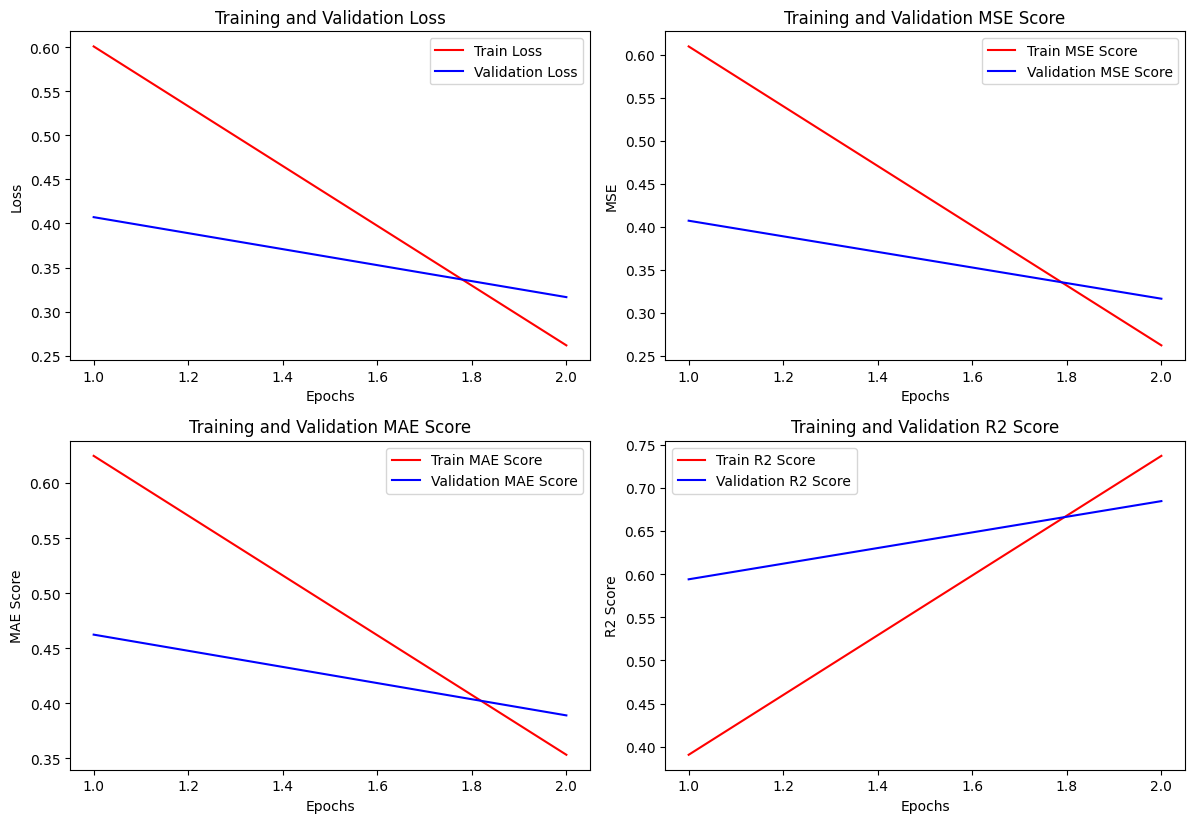

In [11]:
mae_plot_metrics(train_losses, val_losses, train_mse_scores, val_mse_scores, train_mae_scores, val_mae_scores, train_r2_scores, val_r2_scores)

# Plot Reconstructed Image

Total sum of absolute differences: 52341.359375


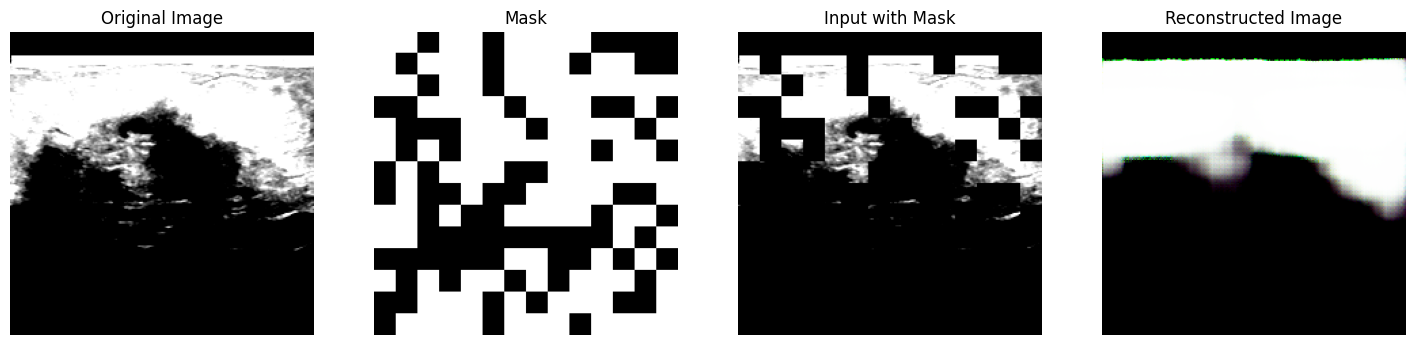

Total sum of absolute differences: 53130.171875


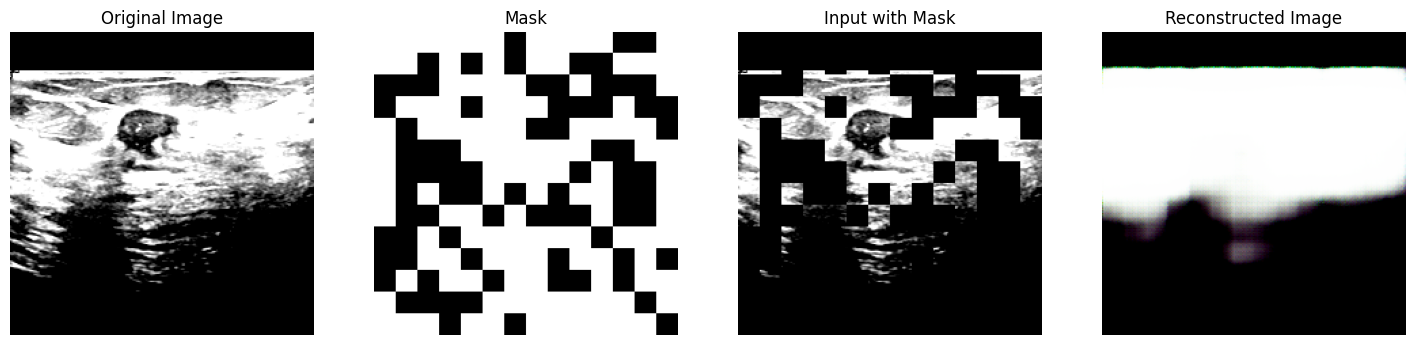

Total sum of absolute differences: 53467.46875


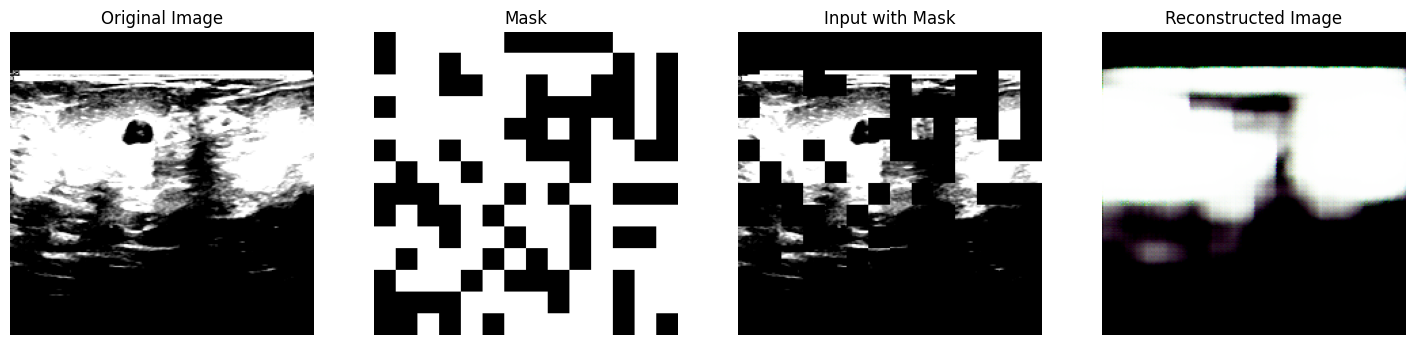

Total sum of absolute differences: 59838.828125


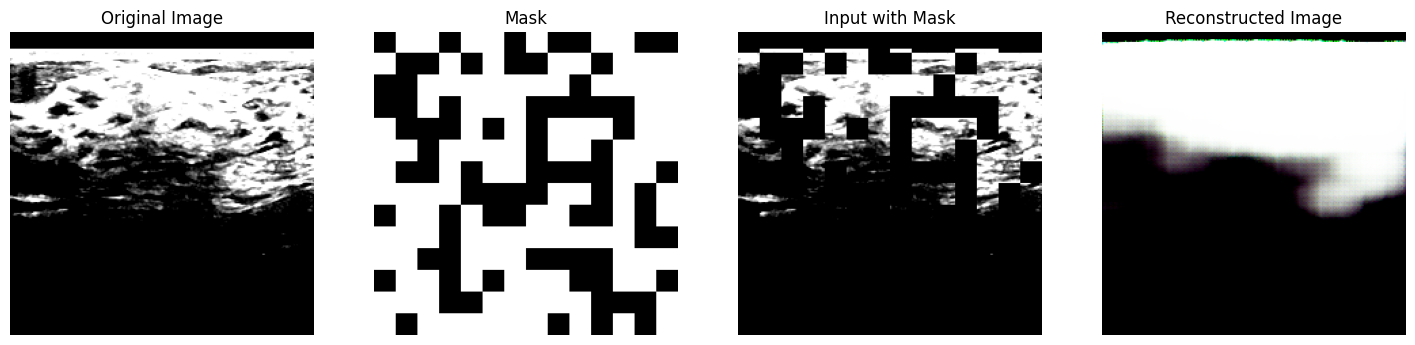

Total sum of absolute differences: 75946.3125


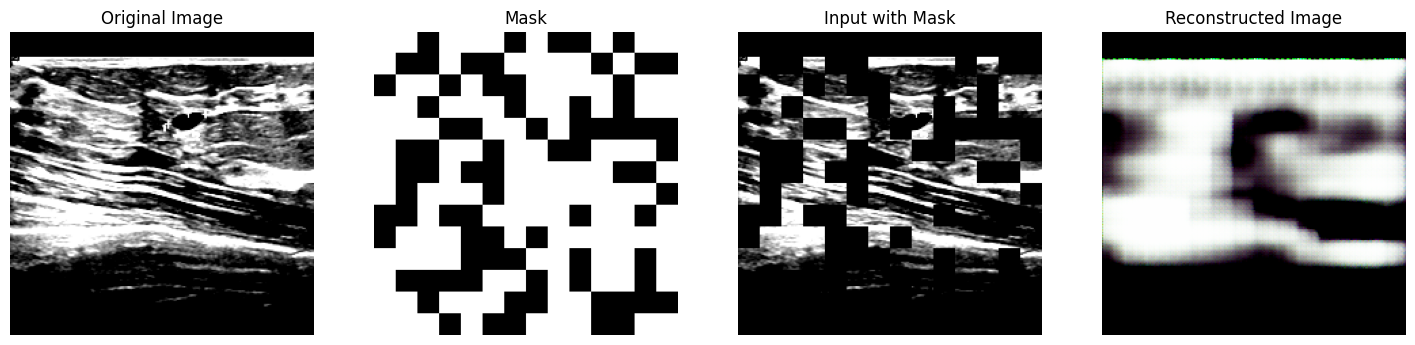

Total sum of absolute differences: 51797.54296875


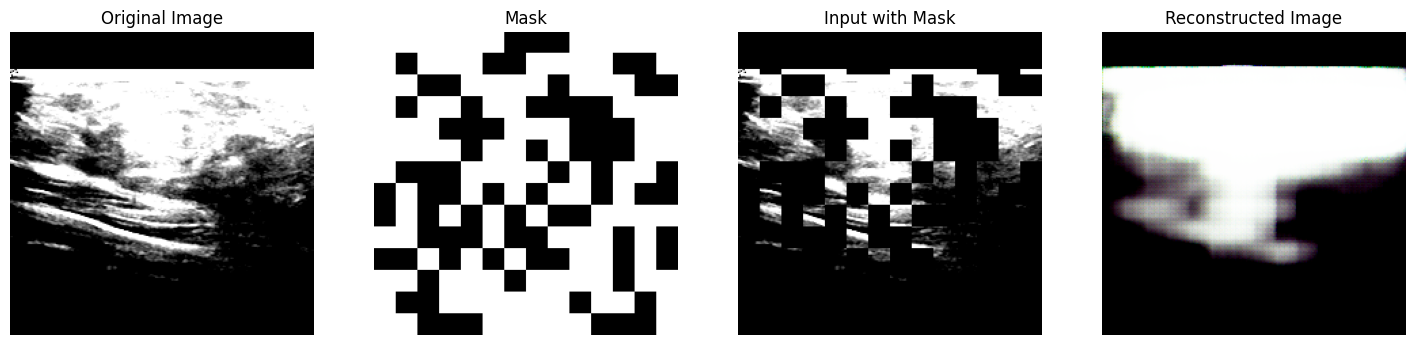

Total sum of absolute differences: 80219.953125


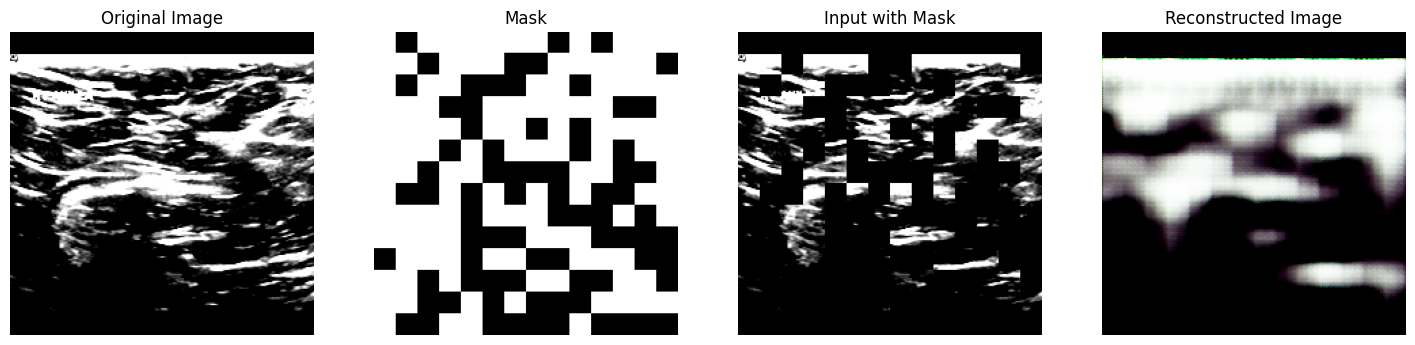

Total sum of absolute differences: 54323.37109375


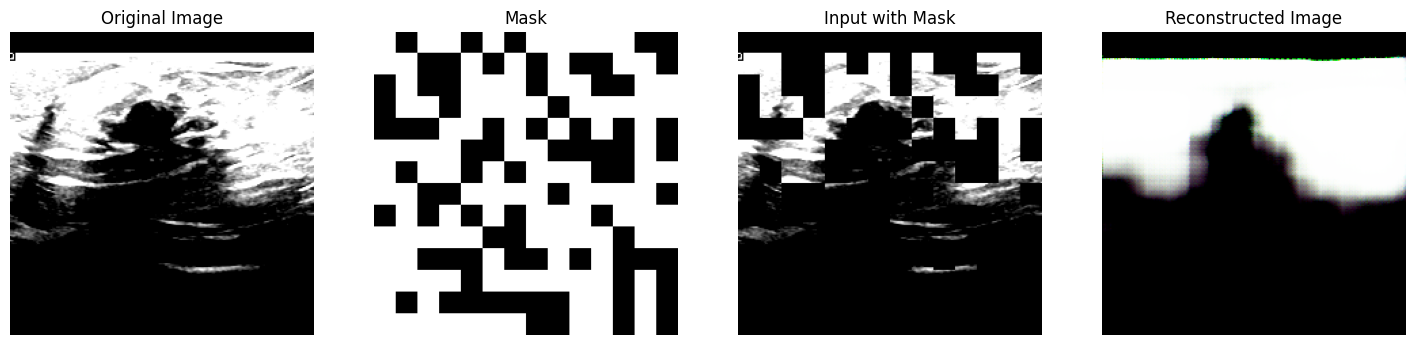

Total sum of absolute differences: 53330.76953125


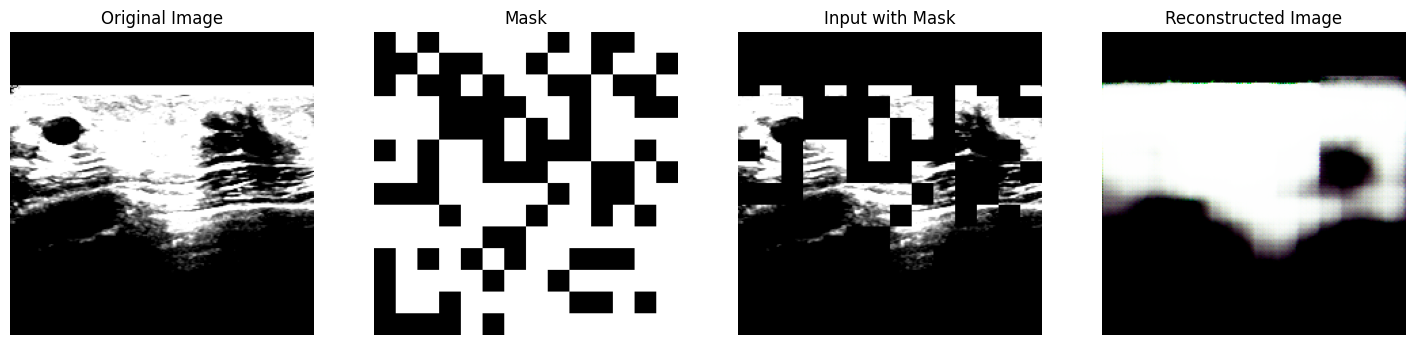

Total sum of absolute differences: 62922.20703125


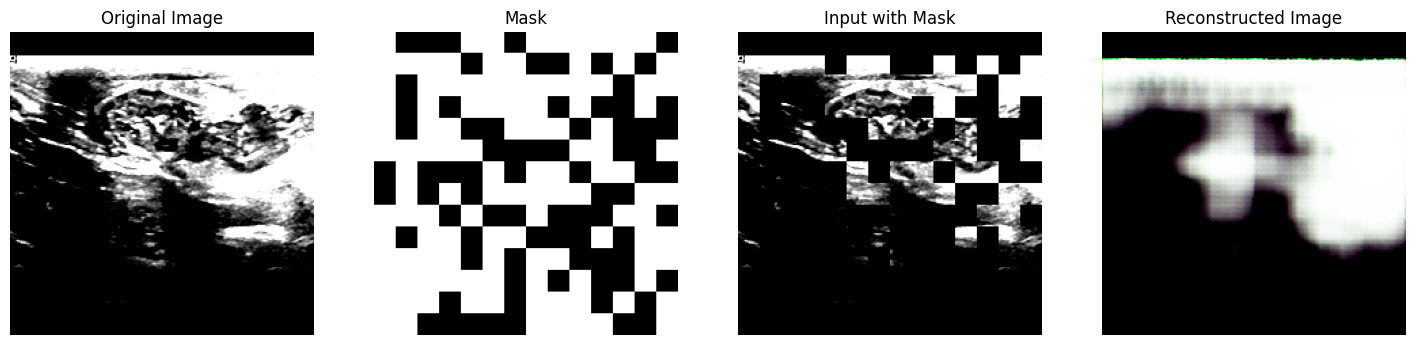

In [12]:
mae_plot_masking_details(model, val_loader, num_images=10)